# Bayesian Inference  of Geospatial Network Models

This paper is a part of my final Master Thesis.

It includes the result of theBayesian Hierarchichal Model inference used in the report as defined as 'Simpler' version but all parameters to run the complet version of the model is present in this notebook.



## Imports and requirements

In [1]:
! pip install numpyro arviz

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
# Removed: Set the JAX_PLATFORMS environment variable to 'cpu'
#os.environ['JAX_PLATFORMS'] = 'cpu'

import argparse
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, jit, grad
from numpyro.infer import MCMC, NUTS, init_to_value, init_to_median

from numpy.testing import suppress_warnings

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from typing import Literal
from itertools import combinations_with_replacement
import time
import arviz as az
import matplotlib
from numpyro.infer import Predictive
import matplotlib.pyplot as plt

from jax.scipy.special import logsumexp
from functools import partial


#matplotlib.use("Agg")  # Use a non-interactive backend for plotting

jax.config.update("jax_enable_x64", False)


#jax.config.update("jax_platform_name", "cpu")

# numpyro.set_platform("cpu") # Removed: Setting platform to cpu explicitly
numpyro.set_host_device_count(jax.device_count()) # Use the actual number of available devices
#numpyro.set_host_device_count(4)



## Helper Functions


In [6]:

@suppress_warnings() # use the suppress_warnings decorator

#### compute blau specific rank distances ###
#### save rank distances and rank distances for selected region pairs only: intra+4nn, intra+40nn, all ###
# version with minus option
def fuzzy_kotsubo_exp_row(pop,dist,nu, k = 10, minus = False, nu_minus = 5, delta = np.log(2)):
    with suppress_warnings() as sup:
        sup.filter(RuntimeWarning, "overflow encountered in exp")
        n = len(pop)
        #print("n : ", n)
        idx_sort = np.argsort(dist)
        #print("idx : ", idx_sort[:5])
        rev_idx_sort = np.argsort(idx_sort)
        #print("rev_idx : ", rev_idx_sort[:5])

        z = np.array(pop)[idx_sort]
        v = np.array(dist)[idx_sort]
        #print("z : ", z[:5])
        #print("v : ", v[:5])

        if not minus:

            Z = np.zeros((k,n))
            V= np.zeros((k,n))
            W_01 = np.zeros((k,n))

            for i in range(1,k+1):
                Z[i-1,:n-i] = z[i:]
                V[i-1,:n-i] = v[i:]
                W_01[i-1,:n-i] = 1

            #print('Z : ', Z[:5,:5])
            #print('V : ', V[:5,:5])

            W = W_01*np.exp( -(1/nu)*np.log(2)*(np.abs(V - v[None,:])))  # absolute value is only for computational purposes, as it evaluates the term inside exp() to a negative value when V = 0 (there are cases with weight W_01 = 0)
            #print("W_01", W_01[:3,:3])
            #print("W", W[:3,:3])

            y = (W*Z).sum(axis = 0) +  np.cumsum(z)
            #print("left : ", np.mean((W*Z).sum(axis = 0)), "right : ", np.mean(np.cumsum(z)))
            #print("y", y[:5])
            return y[rev_idx_sort]

        if minus:
            Z = np.zeros((2*k,n))
            V= np.ones((2*k,n))
            W_01 = np.zeros((2*k,n))
            for i in range(1,k+1):
                #minus
                Z[i-1,i:] = z[:n-i]
                V[i-1,i:] = v[:n-i]
                W_01[i-1,i:] = -1 ###!!! substract some mass of the IOs at smaller distance

                #plus
                Z[i+k-1,:n-i] = z[i:]
                V[i+k-1,:n-i] = v[i:]
                W_01[i+k-1,:n-i] = 1
            W = W_01*np.exp( -np.repeat([delta,0],k)[:,None] -np.repeat([1/nu, 1/nu_minus], k )[:,None]*np.log(2)*np.abs(V - v[None,:]) )
            y = (W*Z).sum(axis = 0) + np.cumsum(z)
            return y[rev_idx_sort]

def get_fuzzy_kotsubo_exp(pop,dist,nu = 5, print_rows = False, k = 10, nu_minus = 5, delta = np.log(2), minus = False):
    pop_dist = np.zeros(dist.shape)
    for i,r in enumerate(dist.index):
        #print(f"Index : {i} , Region : {r}")
        pop_dist[i] = fuzzy_kotsubo_exp_row(pop, dist.loc[r], nu = nu, k = k, nu_minus = nu_minus, delta = delta, minus = minus)
        if print_rows:
            if i%100 == 0:
                print(i)
    pop_dist = pd.DataFrame(pop_dist, index = dist.index, columns = dist.columns)
    return pop_dist


def get_row_col_pairs_from_df(df,pairs):
    if '_' not in pairs[0]:
        if type(pairs[0]) != list:
            raise ValueError('wrong type')
        index = [ i[0]+'_'+i[1] for i in pairs]
        rows, cols = np.array(pairs).T
        row_idx = df.index.get_indexer(rows)
        col_idx = df.columns.get_indexer(cols)
        values = df.to_numpy()[row_idx, col_idx]
        values = pd.Series(values, index = index)
        return(values)
    elif '_to_' in pairs[0]:
        index = pairs
        row_col_pairs = [p.split('_to_') for p in pairs]
        rows, cols = np.array(row_col_pairs).T
        row_idx = df.index.get_indexer(rows)
        col_idx = df.columns.get_indexer(cols)
        values = df.to_numpy()[row_idx, col_idx]
        values = pd.Series(values, index = index)
        return(values)
    elif '_' in pairs[0]:
        index = pairs
        row_col_pairs = [p.split('_') for p in pairs]
        rows, cols = np.array(row_col_pairs).T
        row_idx = df.index.get_indexer(rows)
        col_idx = df.columns.get_indexer(cols)
        values = df.to_numpy()[row_idx, col_idx]
        values = pd.Series(values, index = index)
        return(values)
    else:
        return ValueError('wrong input')


def compute_blau_specific_rank_dist(blau_df, euc_dist, pairs_dict, nu = 4, k = 15):
    cats = list( blau_df.columns )
    # N_cats = len(cats)
    rank_dist_dict = {}
    for name, pairs in pairs_dict.items():
        rank_dist_dict[name] = pd.DataFrame(index = pairs)
    for c, cat in enumerate(cats):
        rank_dist_non_sym = get_fuzzy_kotsubo_exp(blau_df.iloc[:,c], euc_dist, nu = nu, k = k, minus = False)
        rank_dist_geo = (rank_dist_non_sym * rank_dist_non_sym.T)**0.5
        for name, pairs in pairs_dict.items():
            rank_dist_dict[name][cat] = get_row_col_pairs_from_df(rank_dist_geo, pairs)
    return rank_dist_dict


In [4]:
def symmat_from_vec(x, n):
    i, j = jnp.tril_indices(n)
    sbm = jnp.zeros((n, n))
    sbm = sbm.at[i, j].set(x)
    sbm = sbm.at[j, i].set(x)
    return sbm


def get_i1_i2_k_indices(dim):
    i1 = []
    i2 = []
    k = []
    k_ = 0
    for b1 in range(dim):
        for b2 in range(b1+1):
            i1.append(b1)
            i2.append(b2)
            k.append(k_)
            k_ += 1
    return (jnp.array(i1), jnp.array(i2), jnp.array(k))




# helper function for computing overdisperion/concentration of Negative Binomial
@partial(jit, static_argnames=['N_r2'])
def get_phi(a_0, a_1, a_2, b_0, outer_global_std, R_tilde_std, intra_idx, N_r2):
    #N_r2 = outer_global_std.shape[0]
    a0_b0 = jnp.repeat(b_0, N_r2)
    a0_b0 = a0_b0.at[intra_idx].set(a_0)
    return jnp.log1p(jnp.exp( a0_b0 + (a_1 - b_0/10) * outer_global_std + a_2 * R_tilde_std) ) + 0.001

@partial(jit, static_argnames=['N_r2'])
def get_phi_triadic(a_1, a_2, b_0, outer_global_std, R_tilde_std, intra_idx, N_r2):
    #N_r2 = outer_global_std.shape[0]
    a0_b0 = jnp.repeat(b_0, N_r2)
    #a0_b0 = a0_b0.at[intra_idx].set(a_0)
    return jnp.log1p(jnp.exp( a0_b0 + (a_1 - b_0/10) * outer_global_std + a_2 * R_tilde_std) ) + 0.001

# logistic function
@jit
def inv_logit(x):
    return jax.nn.sigmoid(x)

# helper function for adding fixed effects of involved regions per region pair
@jit #partial(jit, static_argnames=["reg1_idx", "reg2_idx", "intra_idx"] )
def get_fixed_effects(effects_per_reg, intra_mean, inter_mean, reg1_idx, reg2_idx, intra_idx):
    effects_per_reg_pair = 0.5 * ( effects_per_reg[reg1_idx] + effects_per_reg[reg2_idx] ) + inter_mean
    effects_per_reg_pair = effects_per_reg_pair.at[intra_idx].add(intra_mean - inter_mean)
    return effects_per_reg_pair


def get_tril_indices(dim):
    idx1, idx2 = jnp.tril_indices(dim)
    return idx1, idx2

@jit
def centering(x):
    return x - x.mean()


def get_P_marg_square_spatial(P0_long_unique_reg_marg, sqr_idx1, sqr_idx2, N_reg):
    P0_marg_square = jnp.zeros( (N_reg, N_reg) )
    def updata_P0_marg(carry, x):
        P, P0_long_unique_reg_marg = carry
        idx1, idx2, k = x
        P = P.at[idx1,k].set(P0_long_unique_reg_marg[idx2])
        return (P,P0_long_unique_reg_marg),None
    (P0_marg_square,_),_ = jax.lax.scan(updata_P0_marg, init = (P0_marg_square,P0_long_unique_reg_marg), xs = (sqr_idx1, sqr_idx2, jnp.arange(N_reg)))
    return P0_marg_square



## Load Dataset, Model Definition and Data Preparation Function

In [5]:

def load_and_prepare_data(distance_path, pop_path, sci_path, area_path):
    # Load datasets
    distance = pd.read_csv(distance_path, sep=';', index_col=0) / 1e3
    pop = pd.read_csv(pop_path)
    SCI = pd.read_csv(sci_path, sep='\t')
    area = pd.read_csv(area_path)
    area = area.drop(columns=['DATAFLOW', 'LAST UPDATE', 'freq', 'landuse', 'unit', 'TIME_PERIOD', 'OBS_FLAG', 'CONF_STATUS'])
    area = area.rename(columns={"geo": "GEO", "OBS_VALUE": "VALUE"})
    area.set_index('GEO', inplace=True)

    # Preprocess population
    pop.loc[pop['AGE'] == 'Y1529', 'VALUE'] *= 17 / 15
    pop = pop.groupby('REGION').sum()['VALUE']
    pop = pop[~pop.index.str.startswith('UK')]

    # Intersection
    valid_regions = sorted(list(pop.index.intersection(distance.index).intersection(area.index)))

    # Filter everything
    SCI = SCI[SCI['user_loc'].isin(valid_regions) & SCI['fr_loc'].isin(valid_regions)]
    distance = distance.loc[valid_regions, valid_regions]
    pop = pop.loc[valid_regions]
    area = area.loc[valid_regions]

    # Matrix SCI
    SCI_matrix = SCI.pivot(index='user_loc', columns='fr_loc', values='scaled_sci')
    all_regions = sorted(valid_regions)
    SCI_matrix = SCI_matrix.reindex(index=all_regions, columns=all_regions, fill_value=0)
    # Intra-regional distances
    radius = np.sqrt(area['VALUE'] / np.pi)
    intra_distance = (2 / 3) * radius
    np.fill_diagonal(distance.values, intra_distance.loc[distance.index].values)

    # Normalize SCI
    n = pop.values.reshape(-1, 1)
    SCI_np = SCI_matrix.values
    SCI_proj = (n.T @ SCI_np @ n) / n.sum()
    c = SCI_proj / 150
    SCI_hat = SCI_np / c
    SCI_hat_matrix = pd.DataFrame(SCI_hat, index=SCI_matrix.index, columns=SCI_matrix.columns)

    pop = pop.astype('float32') / 1e3
    distance = distance.astype('float32')
    area = area.astype('float32')
    SCI_matrix = SCI_matrix.astype('float32')
    SCI_hat_matrix = SCI_hat_matrix.astype('float32')

    return pop, distance, area, SCI_matrix, SCI_hat_matrix


#------------------------------------------------------------------------------------------#
# Spatial Interaction Model#
#------------------------------------------------------------------------------------------#

def model_spatial(  ard, R_tilde_std, outer_global, outer_global_std, euc_dist,
                    N_reg, N_r2,
                    reg1_idx, reg2_idx, intra_idx, ard_zero_idx, ard_one_idx, ard_geq2_idx,
                    FB_marg,
                    pi_zero, pi_one,
                    long_idx = None, sqr_idx1 = None, sqr_idx2 = None, # sqr_idx1_deg, sqr_idx2_deg
                    model_phi = True, include_a0 = False, include_regional_effects = True,
                    triadic = False, quadratic_only = False, sample_p_triadic = True,
                    include_latent = False,
                    include_quadratic = True,
                    flavor : Literal['IO','distance'] = 'IO',
                    p_triadic_prior = None, p_triadic_default = 0.25,
                    f0_sum_to_zero = True,
                    **_
                         ):
    """
    Spatial interaction model for aggregated relational data (ARD).

    Parameters
    ----------
    ard : array_like, shape (N_r2,)
        Empirical aggregated relational data for each region-pair.
    R_tilde_std : array_like, shape (N_r2,)
        Standardized intervening opportunities for each pair.
    outer_global : array_like, shape (N_r2,)
        Number of possible edges for each region pair.
    outer_global_std : array_like, shape (N_r2,)
        Standardized outer_global (for modeling phi).
    euc_dist : array_like, shape (N_r2,)
        Raw Euclidean distances (if `flavor='distance'`, will be log- and std-transformed).
    N_reg : int
        Number of regions.
    N_r2 : int
        Number of unique region pairs considered. May be less than (N_reg*(N_reg+1))//2.
    reg1_idx : array_like, shape (N_r2,)
        For each pair, the index of the first region.
    reg2_idx : array_like, shape (N_r2,)
        For each pair, the index of the second region.
    intra_idx : array_like, shape (N_reg,)
        Integer indices (into the length‐`N_r2` vectors) of the intra‐regional
        pairs (i.e. where reg1_idx == reg2_idx).
    ard_zero_idx, ard_one_idx, ard_geq2_idx : array_like
        Indices of observations with ARD = 0, 1, and >=2, respectively.
    FB_marg : array_like, shape (N_reg,)
        Total number of FB users per region.
    pi_zero, pi_one : float
        Mixing probabilities for zero- and one-inflation components.
    long_idx : array_like, optional
        Flat indices for the “long” (unique pairs) ordering when doing triadic adjustments.
    sqr_idx1, sqr_idx2 : array_like, optional
        Indices for triadic closure
    model_phi : bool, default=True
        Whether to model overdispersion parameter phi via regression on covariates.
    include_a0 : bool, default=False
        If True, include an intercept term a_0 in the phi model (only valid if `model_phi`).
    include_regional_effects : bool, default=True
        Whether to include hierarchical region-specific effects.
    triadic : bool, default=False
        Whether to add triadic closure.
    quadratic_only : bool, default=False
        If True, only use the quadratic component of triadic closure.
    sample_p_triadic : bool, default=True
        Whether to infer p_triadic from data (as Beta) or fix it to `p_triadic_default`.
    include_latent : bool, default=False
        Whether to include latent membership effects via a small SBM.
    include_quadratic : bool, default=True
        Whether to include a quadratic term in the baseline logistic function.
    flavor : {'IO','distance'}, default='IO'
        If 'distance', use log(euc_dist) standardized instead of IOs.
    p_triadic_prior : array_like, shape (2,), optional
        Beta prior hyperparameters for p_triadic; defaults to [1,2] if None.
    p_triadic_default : float, default=0.25
        Fixed triadic probability if `sample_p_triadic=False`.
    f0_sum_to_zero : bool, default=True
        If True, constrain regional effects f_0 and f_1 to sum exactly to zero
        (recommended for HMC; not recommended for SVI).
    **_ : dict
        Catch-all for unused arguments (e.g. helper indices not used).

    """
    #data preparation

    if triadic:
        # with get_deg_square_b helper function
        zeros_N_reg_N_reg = jnp.zeros( (N_reg, N_reg) )
        N_reg_seq = jnp.arange( N_reg )


    if flavor == 'distance':
        log_euc_dist_std = jnp.log(euc_dist)
        log_euc_dist_std = ( log_euc_dist_std - jnp.mean( log_euc_dist_std ) ) / jnp.std( log_euc_dist_std )
        R_tilde_std = log_euc_dist_std
    ################
    # parameters
    ################

    c_0 = numpyro.sample("c_0", dist.Normal(loc = -5, scale = 2) ) # mean intercept, intra regional
    c_1 = numpyro.sample("c_1", dist.TruncatedNormal(loc = 2, scale = 1, low = 0) ) # mean slope, intra regional
    if include_quadratic:
        c_2 = numpyro.sample("c_2", dist.HalfNormal(scale = 1) ) # coefficient for quadratic term

    #d_0 = numpyro.sample("d_0", dist.Normal(loc = -17, scale = 2) ) # mean intercept, inter regional
    #d_1 =  numpyro.sample("d_1", dist.TruncatedNormal(loc = 2, scale = 1, low = 0) ) # mean slope, inter regional
    if model_phi:
        if include_a0:
            a_0 = numpyro.sample("a_0", dist.Normal(loc = 0, scale = 4) ) # intercept for phi, intra regional, skip for triadic
        a_1 = numpyro.sample("a_1", dist.TruncatedNormal(loc = 0.2, scale = 2, low = 0) ) # ceofficent for outer_global_std in phi
        a_2 = numpyro.sample("a_2", dist.Normal(loc = 0, scale = 2) ) # coefficient for R_tilde_std in phi

        b_0 = numpyro.sample("b_0", dist.Normal(loc = 0, scale = 4) ) # intercept for phi, inter regional
    else:
        phi = numpyro.sample("phi", dist.Gamma(2,1) )

    if include_regional_effects:
        f_0_var = numpyro.sample("f_0_var", dist.TruncatedNormal(loc = 0, scale = 1.5, low = 0 ) ) # standard deviation of fixed effects
        f_1_var = numpyro.sample("f_1_var", dist.TruncatedNormal(loc = 0, scale = 1.5, low = 0 ) ) # standard deviation of fixed effects
        if f0_sum_to_zero:
            f_0_raw = numpyro.sample("f_0_raw", dist.Normal(loc = 0, scale = 1).expand((N_reg- 1,) ).mask(False) )# fixed intercept per region
            f_1_raw = numpyro.sample("f_1_raw", dist.Normal(loc = 0, scale = 1).expand((N_reg- 1,) ).mask(False) ) # fixed slope per region

            f_0_raw2 = jnp.append(f_0_raw, -jnp.sum(f_0_raw))
            f_1_raw2 = jnp.append(f_1_raw, -jnp.sum(f_1_raw))

            numpyro.factor('f_0_raw2_log_prob', dist.Normal(0, 1).log_prob(f_0_raw2).sum())
            numpyro.factor('f_1_raw2_log_prob', dist.Normal(0, 1).log_prob(f_1_raw2).sum())
        else:
            f_0_raw2 = numpyro.sample("f_0_raw2", dist.Normal(loc = 0, scale = 1).expand((N_reg,)) ) # fixed intercept per region
            f_1_raw2 = numpyro.sample("f_1_raw2", dist.Normal(loc = 0, scale = 1).expand((N_reg,)) ) # fixed slope per region
        f_0 = numpyro.deterministic("f_0", f_0_raw2 * f_0_var)
        f_1 = numpyro.deterministic("f_1", f_1_raw2 * f_1_var)


    if triadic and sample_p_triadic and ( not quadratic_only ):
        p_triadic = numpyro.sample("p_triadic", dist.Beta( p_triadic_prior[0],p_triadic_prior[1] ) )
    elif triadic and ( not sample_p_triadic ) and ( not quadratic_only ):
        p_triadic = numpyro.deterministic("p_triadic", p_triadic_default)
    if include_latent:
        latent_vector = numpyro.sample("latent_vector", dist.Dirichlet(concentration = jnp.ones(3) ) )
        z = numpyro.sample("z", dist.Beta( 1, 1).expand( (N_reg, ) ) )

    ########################
    # transformed parameters
    ########################

    if include_latent:
        # latent_vector_trs = numpyro.deterministic("latent_vector_trs", jnp.array( [1, latent_vector[0], latent_vector[1:].sum() ] ) )
        latent_vector_trs = numpyro.deterministic("latent_vector_trs", jnp.array( [1, latent_vector[0], latent_vector[0], latent_vector[:2].sum() ] ) )
        z_reg1 = jnp.column_stack( [ z[reg1_idx], z[reg1_idx], (1-z)[reg1_idx], (1-z)[reg1_idx] ] )
        z_reg2 = jnp.column_stack( [ z[reg2_idx], (1-z)[reg2_idx], z[reg2_idx], (1-z)[reg2_idx] ] )
        z_prod = z_reg1 * z_reg2
        z_times_latent_sbm = z_prod @ latent_vector_trs

    if include_regional_effects:
        f_0_effects = get_fixed_effects(f_0, c_0, d_0, reg1_idx, reg2_idx, intra_idx) # add fixed effects of involved regions per region pair
        f_1_effects = get_fixed_effects(f_1, c_1, d_1, reg1_idx, reg2_idx, intra_idx) # add fixed effects of involved regions per region pair
    else:
        f_0_effects = jnp.ones(N_r2) * c_0 #d0
        #f_0_effects = f_0_effects.at[intra_idx].set(c_0)

        f_1_effects = jnp.ones(N_r2) * c_1 #d1
        #f_1_effects = f_1_effects.at[intra_idx].set(c_1)
    # jax.debug.print("f_1_effects shape: {}", f_1_effects.shape)

    ########################
    ########################
    if include_quadratic:
        P0_long_unique_spatial = jax.nn.sigmoid(f_0_effects - f_1_effects * R_tilde_std - c_2 * jnp.square(R_tilde_std))
    else:
        P0_long_unique_spatial =  jax.nn.sigmoid(f_0_effects - f_1_effects * R_tilde_std)

    nu_long = P0_long_unique_spatial * outer_global

    if triadic:
        num_edges_before_closure = nu_long.sum()
        numpyro.deterministic("num_edges_before_closure", num_edges_before_closure )

        P0_square_spatial = get_P_marg_square_spatial(P0_long_unique_spatial, sqr_idx1, sqr_idx2, N_reg)
        # P_square_triadic = get_deg_square_b(P0_long_unique_spatial, sqr_idx1_deg, sqr_idx2_deg, zeros_N_reg_N_reg, N_reg_seq)
        nu_square_triadic = ( FB_marg[:,None] * P0_square_spatial * FB_marg[None,:] ) @ ( P0_square_spatial * FB_marg[None,:] )
        if quadratic_only:
            nu_long = nu_square_triadic.at[jnp.diag_indices(N_reg)].set( 0.5*jnp.diag(nu_square_triadic) ).reshape(-1, order = 'F')[long_idx]
        else:
            nu_long = nu_long + p_triadic * jax.nn.relu( 1 - P0_long_unique_spatial ) * (nu_square_triadic.at[jnp.diag_indices(N_reg)].set( 0.5*jnp.diag(nu_square_triadic) ) ).reshape(-1, order = 'F')[long_idx]

        num_edges_after_closure = nu_long.sum()
        numpyro.deterministic("num_edges_after_closure", num_edges_after_closure )

    numpyro.deterministic("nu_long", nu_long)

    if model_phi:
        if include_a0:
            phi = get_phi(a_0, a_1, a_2, b_0, outer_global_std, R_tilde_std, intra_idx, N_r2)  # over dispersion/concentration parameter per reg_pair, i.e. Var[ARD] = E[ARD] + E^2[ARD]/phi
        else:
            phi = get_phi_triadic(a_1, a_2, b_0, outer_global_std, R_tilde_std, intra_idx, N_r2)  # over dispersion/concentration parameter per reg_pair, i.e. Var[ARD] = E[ARD] + E^2[ARD]/phi

        numpyro.deterministic("phi", phi)
    else:
        phi = jnp.repeat(phi, N_r2)

    if ard is not None:
        ard_geq2 = ard[ard_geq2_idx]
    else:
        ard_geq2 = None

    with numpyro.plate("all_pair", N_r2 ):
        numpyro.sample("obs", dist.NegativeBinomial2(nu_long, phi), obs = ard)


    #with numpyro.plate("ard_geq2_plate", len(ard_geq2_idx) ):
    #    numpyro.sample("obs", dist.NegativeBinomial2(nu_long[ard_geq2_idx], phi[ard_geq2_idx]), obs = ard_geq2)

    #if len(ard_one_idx)>0:
    #    with numpyro.plate('ard_one_plate', size=len(ard_one_idx)): # careful, don't want log_mix over log_lik of whole vector, but log-mix over each data point
    #        comp0 = dist.NegativeBinomial2(nu_long[ard_one_idx], phi[ard_one_idx]).log_prob(0)
    #        comp1 = dist.NegativeBinomial2(nu_long[ard_one_idx], phi[ard_one_idx]).log_prob(1)
    #        comp2 = dist.NegativeBinomial2(nu_long[ard_one_idx], phi[ard_one_idx]).log_prob(2)
    #        comp3 = dist.NegativeBinomial2(nu_long[ard_one_idx], phi[ard_one_idx]).log_prob(3)
    #        log_mix = logsumexp(jnp.stack([comp0, comp1, comp2, comp3], axis=-1), b=pi_one, axis=-1)
    #        numpyro.factor('ard_one_factor', log_mix)
    #if len(ard_zero_idx)>0:
    #    with numpyro.plate('ard_zero_plate', size=len(ard_zero_idx)):
    #        comp0 = dist.NegativeBinomial2(nu_long[ard_zero_idx], phi[ard_zero_idx]).log_prob(0)
    #        comp1 = dist.NegativeBinomial2(nu_long[ard_zero_idx], phi[ard_zero_idx]).log_prob(1)
    #        comp2 = dist.NegativeBinomial2(nu_long[ard_zero_idx], phi[ard_zero_idx]).log_prob(2)
    #        log_mix = logsumexp(jnp.stack([comp0, comp1, comp2], axis=-1), b=pi_zero, axis=-1)
    #        numpyro.factor('ard_zero_factor', log_mix)

    # sum_f_0 = jnp.sum(f_0)
    # numpyro.factor("sum_f_0_constraint", dist.Normal(loc=0, scale=0.001).log_prob(sum_f_0))

    # sum_f_1 = jnp.sum(f_1)
    # numpyro.factor("sum_f_1_constraint", dist.Normal(loc=0, scale=0.001).log_prob(sum_f_1))

    #c1_m_d1 = c_1 - d_1
    #numpyro.factor('c_1_minus_d_1_constraint', dist.Normal(loc=0, scale=0.5).log_prob(c1_m_d1) )

def prepare_model_inputs(pop, distance, SCI_matrix, SCI_hat_matrix):
    # Compute ARD
    pop_values = pop.loc[SCI_hat_matrix.index].values
    pop_product_matrix = pop_values[:, None] * pop_values[None, :]
    ard = SCI_hat_matrix.values * pop_product_matrix
    #ard[SCI_matrix.values == 1] = 0  # Mettre ARD à 0 si SCI_matrix = 1
    ard = pd.DataFrame(ard, index=SCI_hat_matrix.index, columns=SCI_hat_matrix.columns)

    # Intervening Opportunities
    rank_dist = get_fuzzy_kotsubo_exp(pop, distance, nu=5, k=5, minus=False)
    rank_geo = (rank_dist * rank_dist.T)**0.5
    IO_log = np.log(rank_geo.to_numpy()) # take log
    R_tilde_std = (IO_log - np.mean(IO_log)) / np.std(IO_log)

    # Indices
    regions = list(ard.columns)
    N_reg = len(regions)
    pairs = list(combinations_with_replacement(range(N_reg), 2))
    reg1_idx, reg2_idx = zip(*pairs)
    reg1_idx = np.array(reg1_idx)
    reg2_idx = np.array(reg2_idx)
    N_r2 = len(pairs)

    def extract_lower_triangle(matrix):
        i, j = np.tril_indices_from(matrix)# k = 1
        return matrix[i, j]

    ard_vec = extract_lower_triangle(ard.values)
    R_tilde_std_vec = extract_lower_triangle(R_tilde_std)
    outer_global_vec = extract_lower_triangle(pop_product_matrix)
    #outer_global_std_vec = (outer_global_vec - outer_global_vec.mean()) / outer_global_vec.std()
    outer_global_std_vec = (np.log1p(outer_global_vec) - np.log1p(outer_global_vec).mean()) / np.log1p(outer_global_vec).std()

    euc_dist_vec = extract_lower_triangle(distance.values)

    ard_zero_idx = np.where(ard_vec == 0)[0]
    ard_one_idx = np.where(ard_vec == 1)[0]
    ard_geq2_idx = np.where(ard_vec > 1)[0]
    intra_idx = np.where(reg1_idx == reg2_idx)[0]

    FB_marg = np.diag(pop_product_matrix)

    data = {
        "ard": jnp.array(ard_vec),
        "R_tilde_std": jnp.array(R_tilde_std_vec),
        "outer_global": jnp.array(outer_global_vec),
        "outer_global_std": jnp.array(outer_global_std_vec),
        "euc_dist": jnp.array(euc_dist_vec),
        "N_reg": N_reg,
        "N_r2": N_r2,
        "reg1_idx": jnp.array(reg1_idx),
        "reg2_idx": jnp.array(reg2_idx),
        "intra_idx": jnp.array(intra_idx, dtype=int),
        "ard_zero_idx": jnp.array(ard_zero_idx, dtype=int),
        "ard_one_idx": jnp.array(ard_one_idx, dtype=int),
        "ard_geq2_idx": jnp.array(ard_geq2_idx, dtype=int),
        "FB_marg": jnp.array(FB_marg),
        "pi_zero": jnp.array([0.0, 0.0, 1.0]),
        "pi_one": jnp.array([0.0, 0.0, 1.0]),
        "long_idx": jnp.arange(N_r2),
        "sqr_idx1": jnp.arange(N_reg),
        "sqr_idx2": jnp.arange(N_reg),
        "model_phi": True,
        "include_a0": False,
        "include_regional_effects": False,
        "triadic": False,
        "quadratic_only": False,
        "sample_p_triadic": False,
        "include_latent": False,
        "include_quadratic": True,
        "flavor": "IO",
        "p_triadic_prior": jnp.array([1.0, 2.0]),
        "p_triadic_default": 0.25,
        "f0_sum_to_zero": False
    }
    return data

## Data Initialisation

The datasets use are oublicly availaible and sources can be find in the References Section of my Report

In [7]:
distance_path = '/content/drive/MyDrive/RESEARCH/distance_nuts3.csv'
pop_path = '/content/drive/MyDrive/RESEARCH/result.csv'
SCI_path = "/content/drive/MyDrive/RESEARCH/gadm1_nuts3_counties-gadm1_nuts3_counties - FB Social Connectedness Index - October 2021.tsv"
area_path = "/content/drive/MyDrive/RESEARCH/area_nuts3.csv"

pop, distance, area, SCI_matrix, SCI_hat_matrix = load_and_prepare_data(
        distance_path, pop_path, SCI_path, area_path
    )

In [8]:
data = prepare_model_inputs(pop, distance, SCI_matrix, SCI_hat_matrix)

## MCMC Runs

In [28]:
kernel = NUTS(model_spatial, dense_mass=False, target_accept_prob=0.5)
mcmc = MCMC(kernel, num_warmup=1000, num_samples= 400, num_chains=4)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, **data)

/tmp/ipython-input-2916903588.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples= 400, num_chains=4)
sample: 100%|██████████| 1400/1400 [00:20<00:00, 67.54it/s, 15 steps of size 4.41e-01. acc. prob=0.71]


ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2582672000 bytes.

This run is used to reduced memory storage if memory issue encountered. Otherwise, you can run the above blocks. Adapt to your ressources

In [9]:
results = []
kernel = NUTS(model_spatial, dense_mass=False, target_accept_prob=0.5)
for chain_id in range(4):
    rng_key = random.PRNGKey(chain_id)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=500, num_chains=1)
    mcmc.run(rng_key, **data)
    results.append(mcmc.get_samples(group_by_chain=True))


sample: 100%|██████████| 1500/1500 [00:47<00:00, 31.58it/s, 63 steps of size 1.18e-01. acc. prob=0.27]


In [10]:
combined_samples = {
    k: np.concatenate([np.array(r[k]) for r in results], axis=0)
    for k in results[0]
}


## Convergence Checks

In [11]:
idata = az.from_dict(combined_samples)

In [12]:

df = pd.DataFrame(az.summary(idata, var_names=['c_0', 'c_1','c_2','a_1','a_2','b_0']))
print(df)


       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
c_0 -16.774  0.013 -16.799  -16.750      0.001    0.000     569.0     523.0   
c_1   1.293  0.004   1.285    1.301      0.000    0.000     600.0     456.0   
c_2   0.000  0.000   0.000    0.000      0.000    0.000     692.0     544.0   
a_1   0.007  0.007   0.000    0.020      0.000    0.000     360.0     569.0   
a_2   3.269  0.156   2.999    3.594      0.006    0.005     611.0     580.0   
b_0  22.040  0.983  20.380   24.153      0.040    0.030     613.0     606.0   

     r_hat  
c_0   1.01  
c_1   1.00  
c_2   1.00  
a_1   1.01  
a_2   1.00  
b_0   1.00  


       mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
c_0 -16.774  0.013   -16.801    -16.749      0.001    0.000     569.0   
c_1   1.293  0.004     1.285      1.301      0.000    0.000     600.0   
c_2   0.000  0.000     0.000      0.000      0.000    0.000     692.0   
a_1   0.007  0.007     0.000      0.022      0.000    0.000     360.0   
a_2   3.269  0.156     2.999      3.627      0.006    0.005     611.0   
b_0  22.040  0.983    20.016     23.967      0.040    0.030     613.0   

     ess_tail  r_hat  
c_0     523.0   1.01  
c_1     456.0   1.00  
c_2     544.0   1.00  
a_1     569.0   1.01  
a_2     580.0   1.00  
b_0     606.0   1.00  
  parameter    mean  median  hdi_2.5%  hdi_97.5%  eti_3%  eti_97%
0       c_0 -16.774 -16.774   -16.801    -16.749 -16.799  -16.750
1       c_1   1.293   1.293     1.285      1.301   1.285    1.301
2       c_2   0.000   0.000     0.000      0.000   0.000    0.000
3       a_1   0.007   0.005     0.000      0.022   0.000    0.0

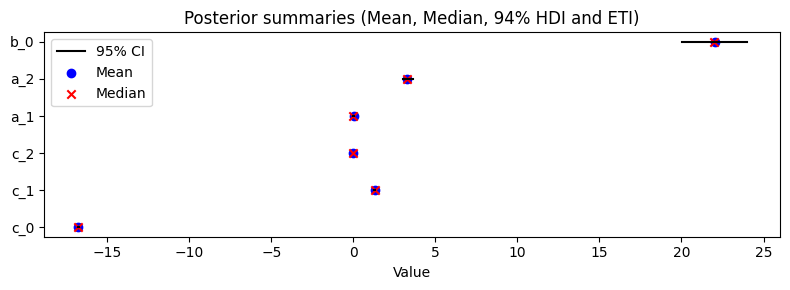

In [93]:
#Posterior summaries
summary = az.summary(idata,  var_names=['c_0', 'c_1','c_2','a_1','a_2','b_0'], hdi_prob=0.95)  # 94% CI
sumary_2 = az.summary(idata,  var_names=['c_0', 'c_1','c_2','a_1','a_2','b_0'], stat_focus='median')
summary_combined = summary.join(sumary_2[['median', 'mad', 'eti_3%', 'eti_97%']], lsuffix='_mean', rsuffix='_median')

#Stock in Dataframe
df = summary_combined[['mean', 'median', 'hdi_2.5%', 'hdi_97.5%', 'eti_3%', 'eti_97%']].reset_index()
df = df.rename(columns={'index':'parameter'})
print(df)

# Plot Checks
plt.figure(figsize=(8, len(df)*0.5))
for i, row in df.iterrows():
    plt.plot([row['hdi_2.5%'], row['hdi_97.5%']], [i, i], color='black', label='95% CI' if i==0 else "")  # 94% CI line
    plt.scatter(row['mean'], i, color='blue', label='Mean' if i==0 else "")
    plt.scatter(row['median'], i, color='red', marker='x', label='Median' if i==0 else "")

plt.yticks(range(len(df)), df['parameter'])
plt.xlabel("Value")
plt.title("Posterior summaries (Mean, Median, 94% HDI and ETI)")
plt.legend()
plt.tight_layout()
plt.show()

As mentionned in the Report, we noticed very low standard deviations probably due to the oversimplifeid model.

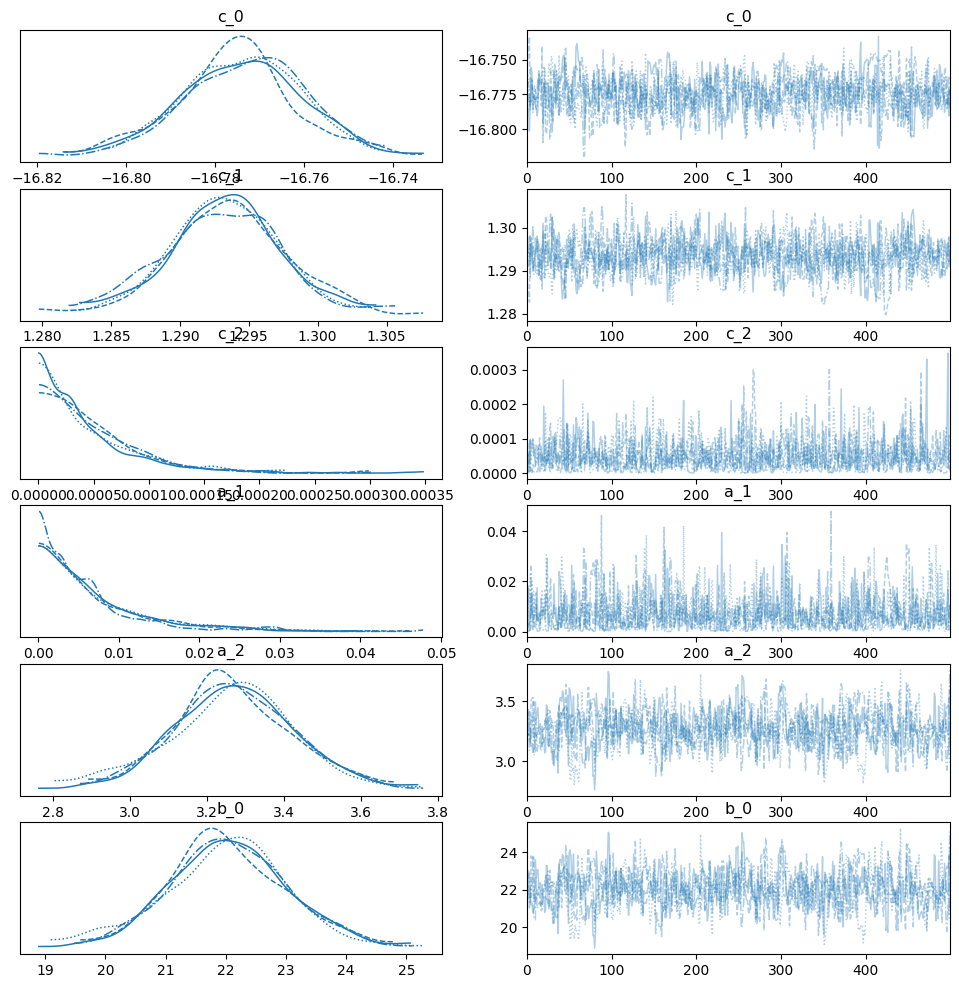

In [13]:
az.plot_trace(idata, var_names=['c_0', 'c_1','c_2','a_1','a_2','b_0'], compact = True)
plt.show()

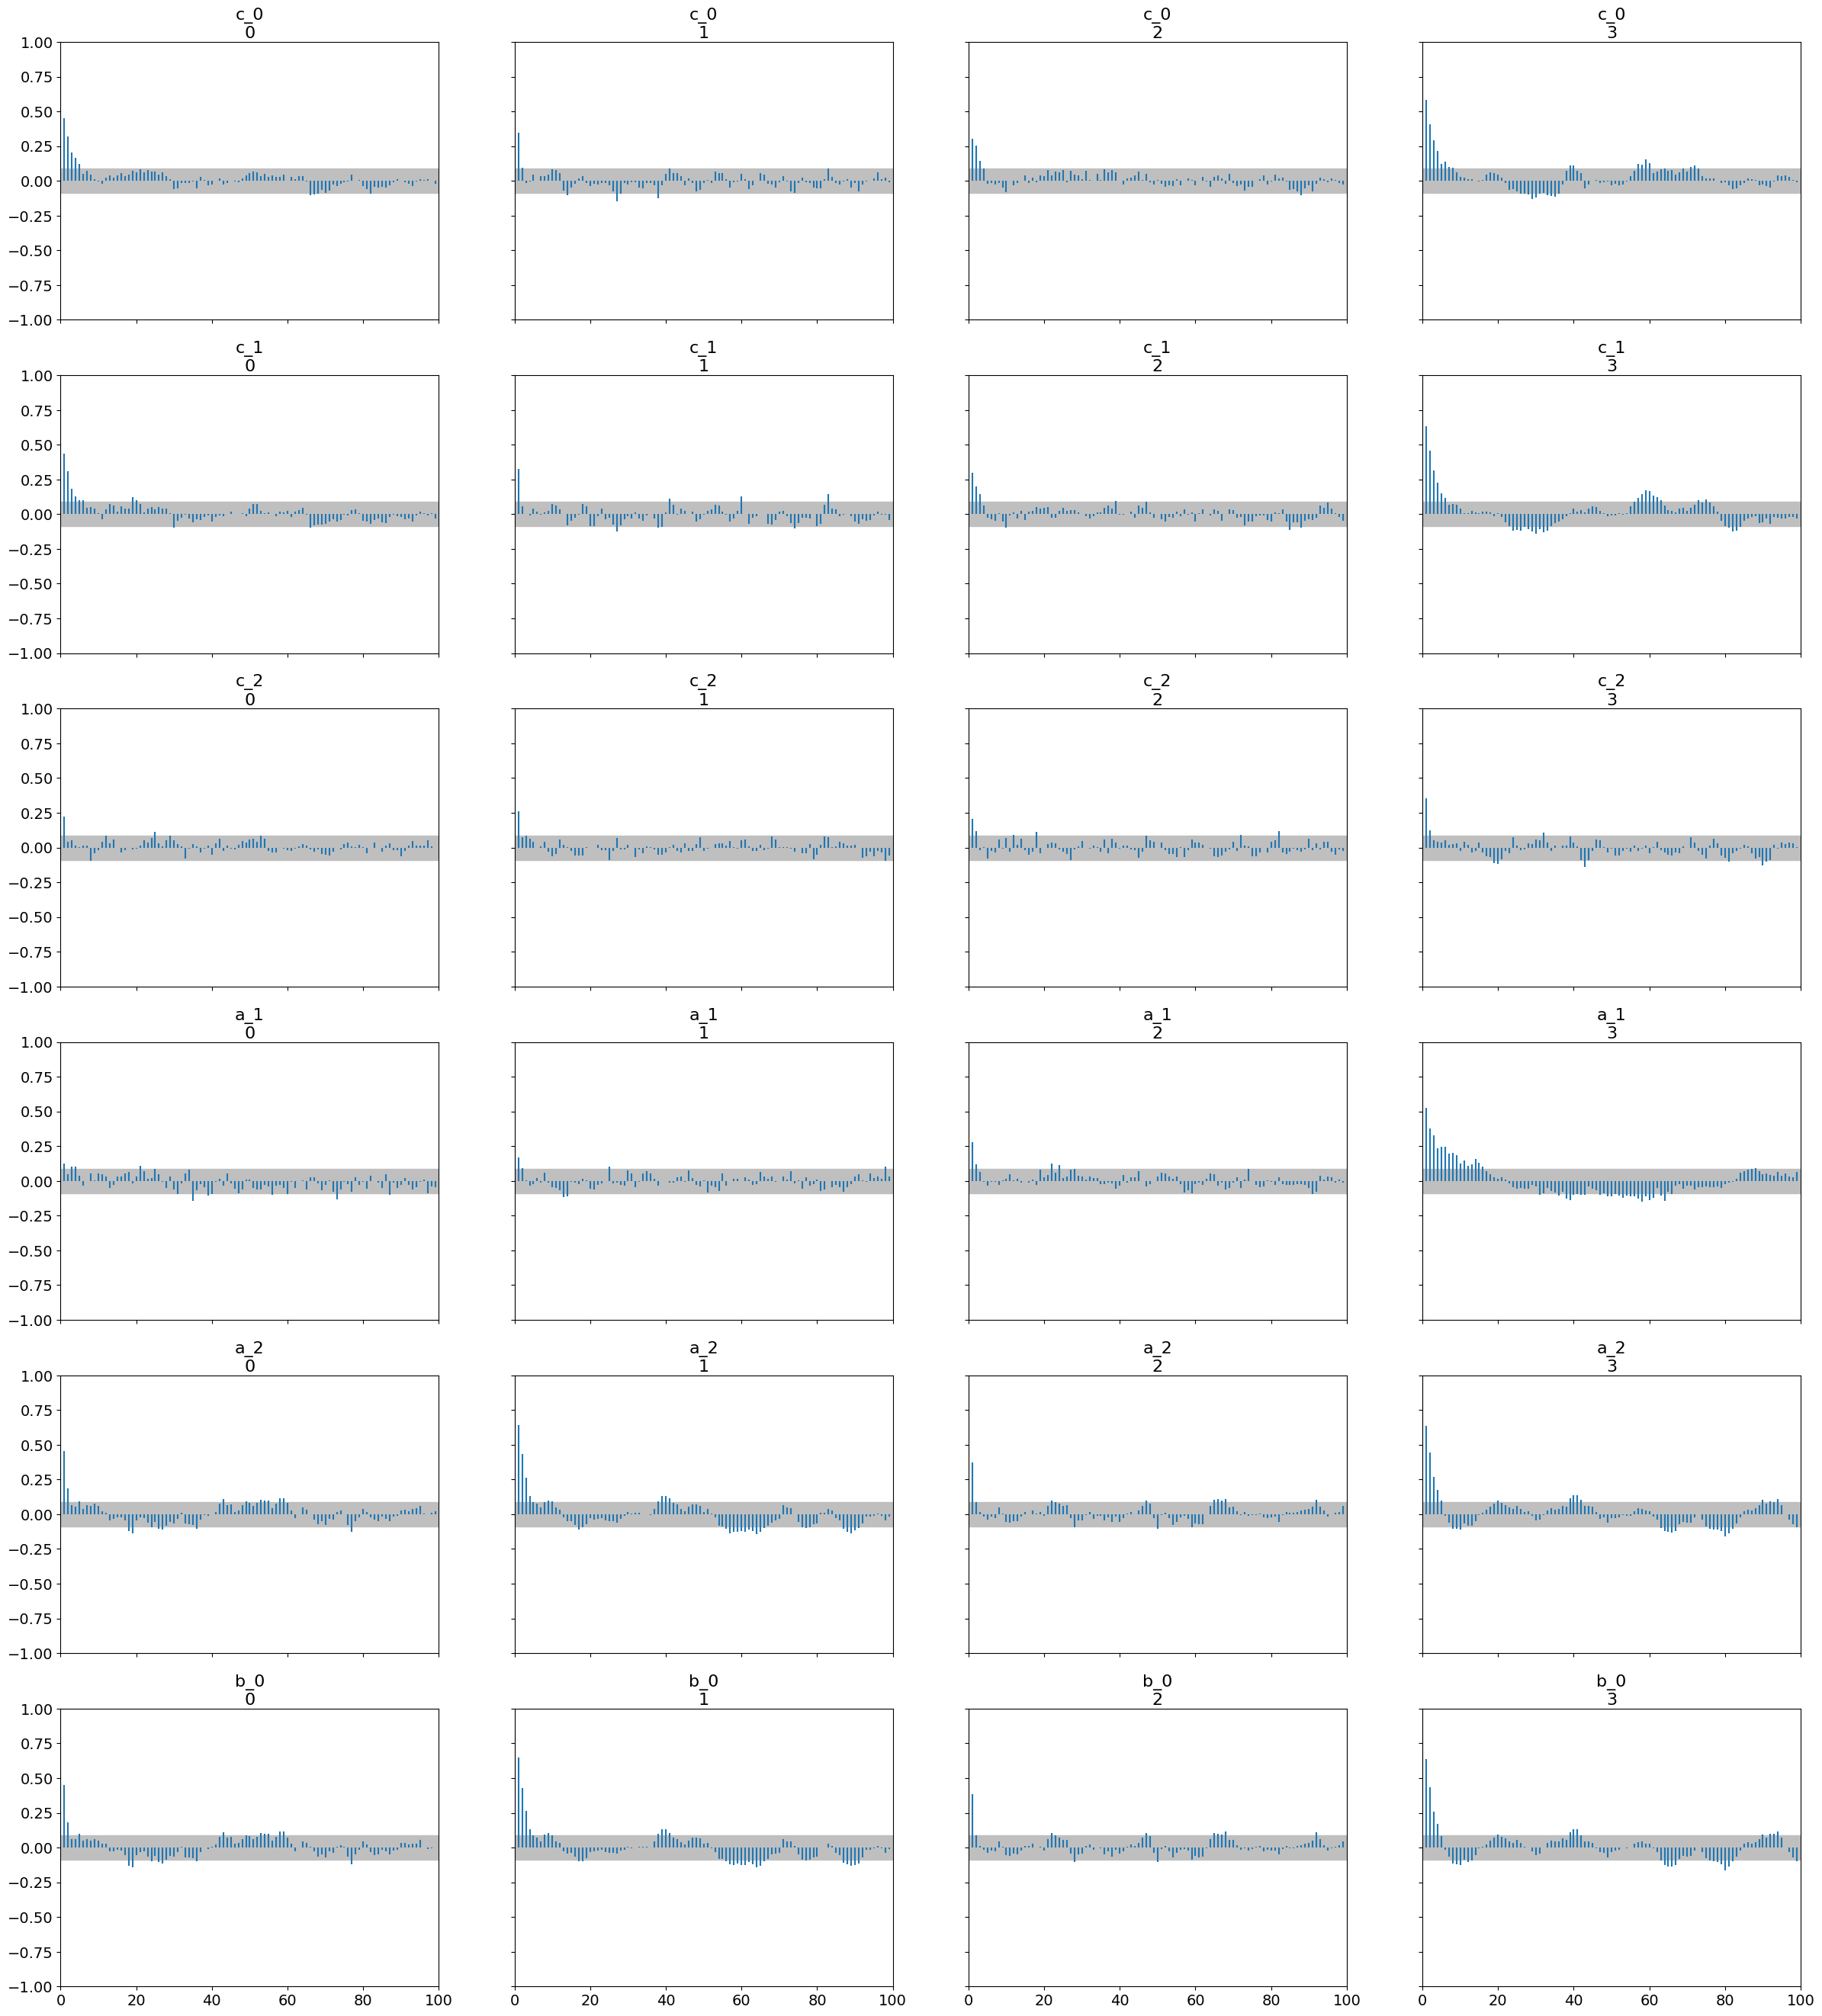

In [14]:
az.plot_autocorr(idata, var_names=['c_0', 'c_1','c_2','a_1','a_2','b_0'])
plt.show()

# Posterior Predictive Checks

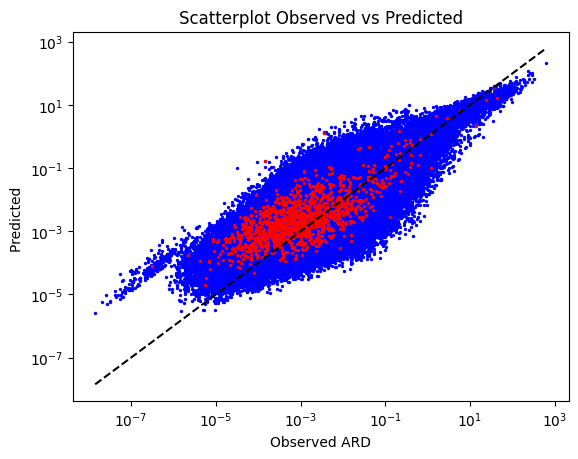

In [60]:
nu_long = idata.posterior['nu_long'].values.mean(axis = (0,1))
ard_vec = data['ard']
intra_idx = data['intra_idx']
plt.scatter(ard_vec,nu_long, s = 2,c='b')
plt.scatter(ard_vec[intra_idx],nu_long[intra_idx], s = 2, c='r')
lims = [min(ard_vec.min(), nu_long.min()), max(ard_vec.max(), nu_long.max())]
plt.plot(lims, lims, 'k--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Observed ARD")
plt.ylabel("Predicted ")
plt.title("Scatterplot Observed vs Predicted")
plt.show()
plt.show()




/tmp/ipython-input-1667408321.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby("bin").agg(


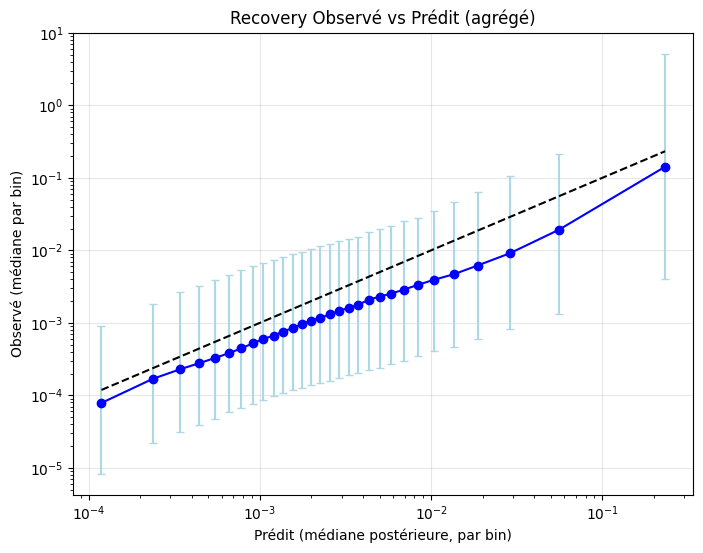

In [58]:

# Extraire les échantillons de nu_long
nu_long_samples = idata.posterior['nu_long'].values.reshape(-1, idata.posterior['nu_long'].shape[-1])

# Médiane prédite
nu_median = np.median(nu_long_samples, axis=0)

# Observé
ard_vec = np.array(data['ard'])

# Mettre dans un DataFrame
df = pd.DataFrame({
    "obs": ard_vec,
    "pred": nu_median
})

# Binning en 30 quantiles (modifiable selon la finesse voulue)
df["bin"] = pd.qcut(df["pred"], q=30, duplicates="drop")

agg = df.groupby("bin").agg(
    pred_median=("pred","median"),
    obs_median=("obs","median"),
    obs_q05=("obs", lambda x: np.percentile(x, 5)),
    obs_q95=("obs", lambda x: np.percentile(x, 95))
)

# Plot
plt.figure(figsize=(8,6))
plt.errorbar(agg["pred_median"], agg["obs_median"],
             yerr=[agg["obs_median"]-agg["obs_q05"], agg["obs_q95"]-agg["obs_median"]],
             fmt='o-', color="blue", ecolor="lightblue", capsize=3)

lims = [agg["pred_median"].min(), agg["pred_median"].max()]
plt.plot(lims, lims, 'k--')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Predicted Post-median per bin")
plt.ylabel("Observed Median per bin")
plt.grid(alpha=0.3)
plt.show()

The data has benn binned to avoid OOM issues

In [63]:
agg

,pred_median,obs_median,obs_q05,obs_q95
bin,,,,
"(-0.00099746, 0.000181]",0.000119,0.000079,0.000008,0.000906
"(0.000181, 0.000288]",0.000236,0.000168,0.000022,0.001841
"(0.000288, 0.00039]",0.000340,0.000228,0.000031,0.002637
"(0.00039, 0.000494]",0.000442,0.000278,0.000039,0.003237
"(0.000494, 0.000602]",0.000547,0.000328,0.000047,0.003881
"(0.000602, 0.000718]",0.000660,0.000382,0.000059,0.004524
"(0.000718, 0.000843]",0.000780,0.000445,0.000068,0.005363
"(0.000843, 0.000978]",0.000909,0.000522,0.000076,0.006083
"(0.000978, 0.00113]",0.001050,0.000600,0.000087,0.006627


/tmp/ipython-input-2499137251.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hpdi = az.hdi(np.array(nu_long_samples[:, sample_idx]), hdi_prob=0.9).T
/tmp/ipython-input-2499137251.py:11: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  res_hpdi = az.hdi(np.array(residuals), hdi_prob=0.9).T


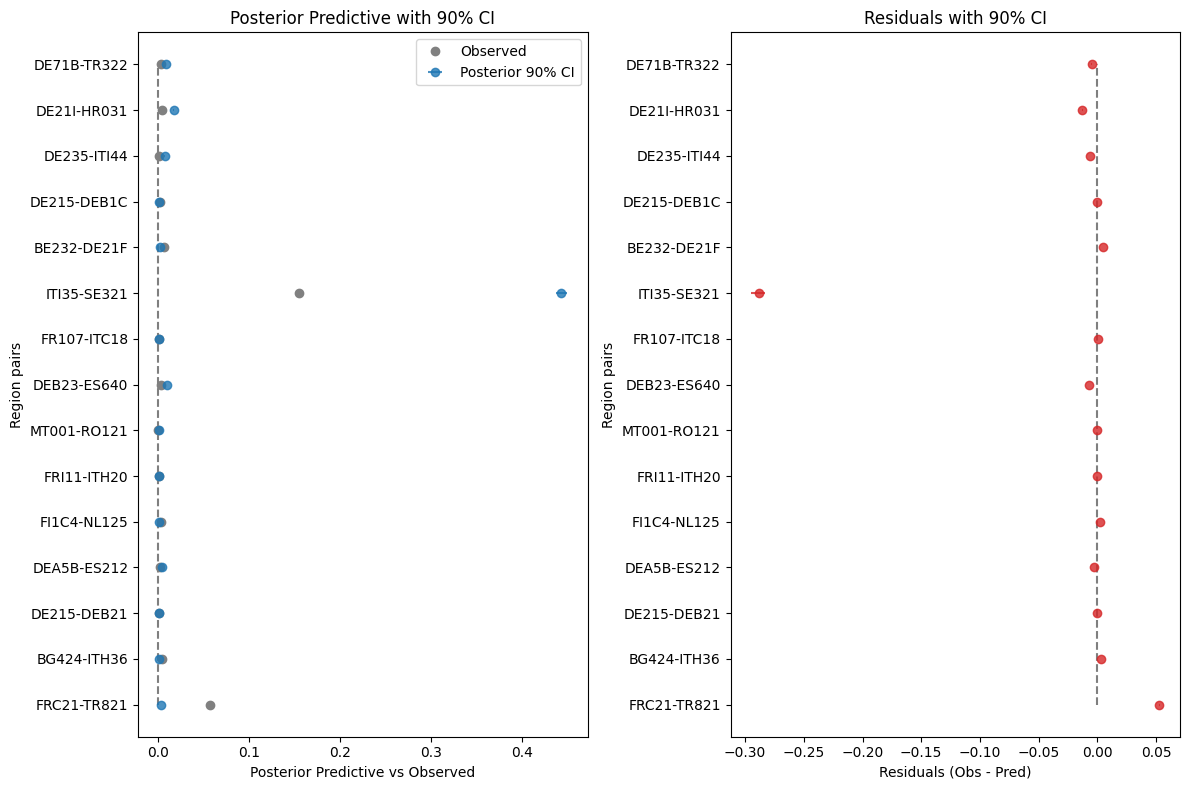

In [95]:
# Under sample to avoid Memory Issue

np.random.seed(42)
sample_idx = np.random.choice(len(ard_vec), size=15, replace=False)
nu_long_samples = np.array(nu_long_samples)

# Post Predictive Means and REsiduams
pred_mean = nu_long_samples[:, sample_idx].mean(axis=0)
pred_hpdi = az.hdi(np.array(nu_long_samples[:, sample_idx]), hdi_prob=0.9).T

residuals = ard_vec[sample_idx] - np.array(nu_long_samples[:, sample_idx])
res_mean = residuals.mean(axis=0)
res_hpdi = az.hdi(np.array(residuals), hdi_prob=0.9).T

y = np.arange(len(sample_idx))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
SCI_idx = np.array(SCI_hat_matrix.index)

# --- Posterior predictive vs Observed ---
ax[0].plot(np.zeros(len(y)), y, "--", color="k", alpha=0.5)
ax[0].errorbar(pred_mean, y,
               xerr=[pred_mean - pred_hpdi[0], pred_hpdi[1] - pred_mean],
               fmt="o", color="tab:blue", alpha=0.8, label="Posterior 90% CI")
ax[0].plot(ard_vec[sample_idx], y, "o", color="gray", label="Observed")
ax[0].set(xlabel="Posterior Predictive vs Observed",
          ylabel="Region pairs", title="Posterior Predictive with 90% CI")
ax[0].set_yticks(y)
ax[0].set_yticklabels([f"{SCI_idx[data['reg1_idx'][i]]}-{SCI_idx[data['reg2_idx'][i]]}" for i in sample_idx])
ax[0].legend()

# --- Residuals ---
ax[1].plot(np.zeros(len(y)), y, "--", color="k", alpha=0.5)
ax[1].errorbar(res_mean, y,
               xerr=[res_mean - res_hpdi[0], res_hpdi[1] - res_mean],
               fmt="o", color="tab:red", alpha=0.8)
ax[1].set(xlabel="Residuals (Obs - Pred)", ylabel="Region pairs",
          title="Residuals with 90% CI")
ax[1].set_yticks(y)
ax[1].set_yticklabels([f"{SCI_idx[data['reg1_idx'][i]]}-{SCI_idx[data['reg2_idx'][i]]}" for i in sample_idx])

plt.tight_layout()
plt.show()
